## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.optimize import curve_fit

import datetime
import openpyxl
import os
from tqdm import tqdm

%matplotlib inline

## Custom functions

In [2]:
def one_phase_decay(x, Y0, Plateau, K):
    """
    Calculates the one phase decay of a signal. One phase decay equation from GraphPad Prism.

    Returns:
    numpy array: The decay of the signal over time.
    """
    return (Y0 - Plateau)*np.exp(-K*x) + Plateau


def wl_to_index(wl, df_blanked):
    """
    Converts a wavelength value to its corresponding index in a dataframe.

    Parameters:
    wl (float): The wavelength value to be converted.
    df_blanked (pandas DataFrame): The dataframe containing the wavelength values.

    Returns:
    int: The index of the corresponding wavelength in the dataframe.
    """
    df2 = df_blanked['Wavelength']
    return df2.index[df2['Time [min]']==wl][0]


    
def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False, 
                       **to_excel_kwargs):
    """
    Append a DataFrame [df] to existing Excel file [filename]
    into [sheet_name] Sheet.
    If [filename] doesn't exist, then this function will create it.

    @param filename: File path or existing ExcelWriter
                     (Example: '/path/to/file.xlsx')
    @param df: DataFrame to save to workbook
    @param sheet_name: Name of sheet which will contain DataFrame.
                       (default: 'Sheet1')
    @param startrow: upper left cell row to dump data frame.
                     Per default (startrow=None) calculate the last row
                     in the existing DF and write to the next row...
    @param truncate_sheet: truncate (remove and recreate) [sheet_name]
                           before writing DataFrame to Excel file
    @param to_excel_kwargs: arguments which will be passed to `DataFrame.to_excel()`
                            [can be a dictionary]
    @return: None

    Usage examples:

    >>> append_df_to_excel('d:/temp/test.xlsx', df)

    >>> append_df_to_excel('d:/temp/test.xlsx', df, header=None, index=False)

    >>> append_df_to_excel('d:/temp/test.xlsx', df, sheet_name='Sheet2',
                           index=False)

    >>> append_df_to_excel('d:/temp/test.xlsx', df, sheet_name='Sheet2', 
                           index=False, startrow=25)

    (c) [MaxU](https://stackoverflow.com/users/5741205/maxu?tab=profile)
    """
    # Excel file doesn't exist - saving and exiting
    if not os.path.isfile(filename):
        df.to_excel(
            filename,
            sheet_name=sheet_name, 
            startrow=startrow if startrow is not None else 0, 
            **to_excel_kwargs)
        return
    
    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl', mode='a')

    # try to open an existing workbook
    writer.book = openpyxl.load_workbook(filename)
    
    # get the last row in the existing Excel sheet
    # if it was not specified explicitly
    if startrow is None and sheet_name in writer.book.sheetnames:
        startrow = writer.book[sheet_name].max_row

    # truncate sheet
    if truncate_sheet and sheet_name in writer.book.sheetnames:
        # index of [sheet_name] sheet
        idx = writer.book.sheetnames.index(sheet_name)
        # remove [sheet_name]
        writer.book.remove(writer.book.worksheets[idx])
        # create an empty sheet [sheet_name] using old index
        writer.book.create_sheet(sheet_name, idx)
    
    # copy existing sheets
    writer.sheets = {ws.title:ws for ws in writer.book.worksheets}

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()

## Input

In [3]:
### User input 
# File:
file = 'raw_data.xlsx'

# Sheet names: 
plate_sheet = 'Plate layout'
raw_data_sheet = 'Raw data'

# Read data
df_names = pd.read_excel(file, sheet_name=plate_sheet, nrows=9, usecols=range(1,13))
df_raw = pd.read_excel(file, sheet_name=raw_data_sheet, header=[0,1]).swaplevel(axis=1)

In [4]:
### Other input 
date = datetime.date.today().strftime('%Y%m%d')
conditions = list(dict.fromkeys(df_names.iloc[8].to_list()))

# determine timepoints and wavelengths
timepoints_list = df_raw.columns.levels[1].tolist()[:-1]
timepoints = len(timepoints_list)
w_min = df_raw['Wavelength'].min()[0]
w_max = df_raw['Wavelength'].max()[0]

# output file
workbook_name = 'output_'+date+'.xlsx'
sheet_name = 'Results'
fig_col = 'CI'

## Data import and processing

In [5]:
### Prepare well labels
df_names.columns = df_names.iloc[8]
df_names = df_names.iloc[0:8]

cpds = df_names.values.ravel()

cpd_con = pd.DataFrame([cpds,conditions*16]).transpose()

cpd_con['cpd_con'] = cpd_con[cpd_con.columns].apply(
    lambda x: '_'.join(x.astype(str)),
    axis=1
)

# Create an array of strings representing column labels in a 12x8 grid
codes = np.array(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10',
       'B11', 'B12', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7',
       'D8', 'D9', 'D10', 'D11', 'D12', 'E1', 'E2', 'E3', 'E4', 'E5',
       'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F1', 'F2', 'F3',
       'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G1',
       'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11',
       'G12', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10',
       'H11', 'H12'])

# Combine the previously created dataframe with the array of strings
names_codes = pd.DataFrame({'Name':cpd_con['cpd_con'], 'Code':codes})

# Add row and col columns
names_codes['Row'] = names_codes['Code'].apply(lambda x: x[0])
names_codes['Col'] = names_codes['Code'].apply(lambda x: x[1:]) 
names_codes['Col'] = names_codes['Col'].astype('int') # convert to integer

# Check the layout
names_codes.pivot(index='Row', columns='Col', values='Name')

Col,1,2,3,4,5,6,7,8,9,10,11,12
Row,,,,,,,,,,,,
A,blank1_buffer,blank1_0.5 mM TCEP,blank1_0.5 mM L-Lys,blank1_0.5 mM L-Ser,blank1_0.5 mM NAcCys,blank1_0.5 mM L-Cys,blank2_buffer,blank2_0.5 mM TCEP,blank2_0.5 mM L-Lys,blank2_0.5 mM L-Ser,blank2_0.5 mM NAcCys,blank2_0.5 mM L-Cys
B,cpd_01_buffer,cpd_01_0.5 mM TCEP,cpd_01_0.5 mM L-Lys,cpd_01_0.5 mM L-Ser,cpd_01_0.5 mM NAcCys,cpd_01_0.5 mM L-Cys,cpd_07_buffer,cpd_07_0.5 mM TCEP,cpd_07_0.5 mM L-Lys,cpd_07_0.5 mM L-Ser,cpd_07_0.5 mM NAcCys,cpd_07_0.5 mM L-Cys
C,cpd_08_buffer,cpd_08_0.5 mM TCEP,cpd_08_0.5 mM L-Lys,cpd_08_0.5 mM L-Ser,cpd_08_0.5 mM NAcCys,cpd_08_0.5 mM L-Cys,cpd_13_buffer,cpd_13_0.5 mM TCEP,cpd_13_0.5 mM L-Lys,cpd_13_0.5 mM L-Ser,cpd_13_0.5 mM NAcCys,cpd_13_0.5 mM L-Cys
D,cpd_04_buffer,cpd_04_0.5 mM TCEP,cpd_04_0.5 mM L-Lys,cpd_04_0.5 mM L-Ser,cpd_04_0.5 mM NAcCys,cpd_04_0.5 mM L-Cys,cpd_33_buffer,cpd_33_0.5 mM TCEP,cpd_33_0.5 mM L-Lys,cpd_33_0.5 mM L-Ser,cpd_33_0.5 mM NAcCys,cpd_33_0.5 mM L-Cys
E,cpd_11_buffer,cpd_11_0.5 mM TCEP,cpd_11_0.5 mM L-Lys,cpd_11_0.5 mM L-Ser,cpd_11_0.5 mM NAcCys,cpd_11_0.5 mM L-Cys,cpd_37_buffer,cpd_37_0.5 mM TCEP,cpd_37_0.5 mM L-Lys,cpd_37_0.5 mM L-Ser,cpd_37_0.5 mM NAcCys,cpd_37_0.5 mM L-Cys
F,cpd_16_buffer,cpd_16_0.5 mM TCEP,cpd_16_0.5 mM L-Lys,cpd_16_0.5 mM L-Ser,cpd_16_0.5 mM NAcCys,cpd_16_0.5 mM L-Cys,cpd_39_buffer,cpd_39_0.5 mM TCEP,cpd_39_0.5 mM L-Lys,cpd_39_0.5 mM L-Ser,cpd_39_0.5 mM NAcCys,cpd_39_0.5 mM L-Cys
G,cpd_21_buffer,cpd_21_0.5 mM TCEP,cpd_21_0.5 mM L-Lys,cpd_21_0.5 mM L-Ser,cpd_21_0.5 mM NAcCys,cpd_21_0.5 mM L-Cys,cpd_40_buffer,cpd_40_0.5 mM TCEP,cpd_40_0.5 mM L-Lys,cpd_40_0.5 mM L-Ser,cpd_40_0.5 mM NAcCys,cpd_40_0.5 mM L-Cys
H,cpd_25_buffer,cpd_25_0.5 mM TCEP,cpd_25_0.5 mM L-Lys,cpd_25_0.5 mM L-Ser,cpd_25_0.5 mM NAcCys,cpd_25_0.5 mM L-Cys,cpd_45_buffer,cpd_45_0.5 mM TCEP,cpd_45_0.5 mM L-Lys,cpd_45_0.5 mM L-Ser,cpd_45_0.5 mM NAcCys,cpd_45_0.5 mM L-Cys


In [6]:
### Process raw data
# rename MultiIndex columns
cols_new = [('Wavelength', 'Time [min]')]
for (x,y) in df_raw.columns.tolist()[1:]:
    x1 = names_codes[names_codes['Code']==x]['Name'].tolist()[0]
    cols_new.append((x1,y))

df_raw.columns = pd.MultiIndex.from_tuples(cols_new)

## Subtract blank: subtract first row for each column and each timepoint
# loop through timepoints
df_blanked = pd.DataFrame()
for t in timepoints_list:
    df_temp = pd.DataFrame()
    df_temp = df_raw.xs(t, level=1, drop_level=False,axis=1)
    
    # loop through each column on microwell plate 
    df_diff_col = pd.DataFrame()
    for col in names_codes['Col'].unique():
        blank = names_codes[(names_codes['Col']==col) & (names_codes['Row']=='A')]['Name']
        
        # loop through each row on microwell plate  
        df_diff_row = pd.DataFrame()
        for row in names_codes['Row'].unique()[1:]:
            compound = names_codes[(names_codes['Col']==col) & (names_codes['Row']==row)]['Name']

            # subtract first row for each well
            array_temp = df_temp[compound].iloc[:,0] - df_temp[blank].iloc[:,0] # convert from dataframe to array (becasue of multiindex)
            df_from_array = pd.DataFrame(array_temp, columns=compound) # convert back to dataframe
            df_from_array.columns = pd.MultiIndex.from_product([df_from_array.columns, [t]]) # convert back to multiindex

            # concat rows
            df_diff_row = pd.concat([df_diff_row, df_from_array], axis=1)
            
        # concat columns
        df_diff_col = pd.concat([df_diff_col, df_diff_row], axis=1)
            
    # concat timepoints
    df_blanked = pd.concat([df_blanked, df_diff_col], axis=1)
    
# add column with wavelengths
df_blanked['Wavelength'] = df_raw.iloc[:,0]
df_blanked.columns = pd.MultiIndex.from_tuples(df_blanked.columns[:-1].tolist() + [('Wavelength', 'Time [min]')]) 

## Data analysis

 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:09<00:03,  1.12it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:13<00:00,  1.06it/s]


Finished


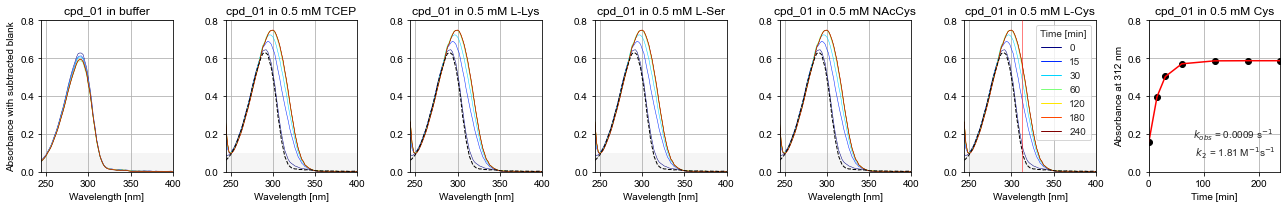

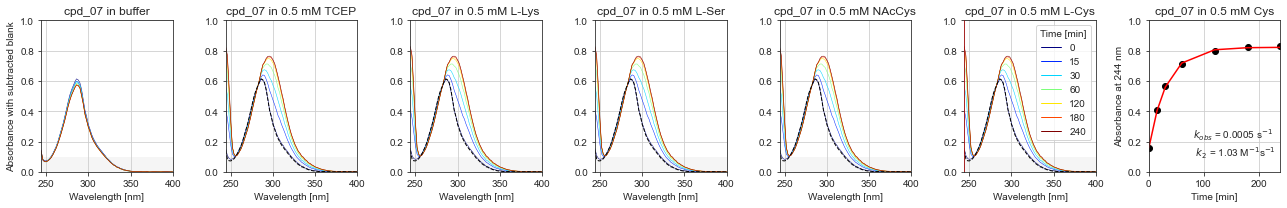

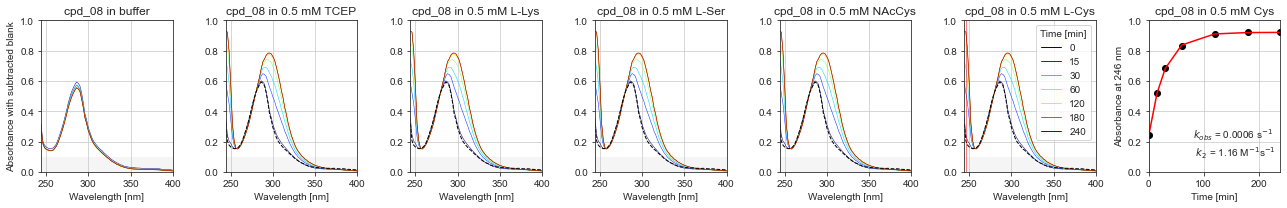

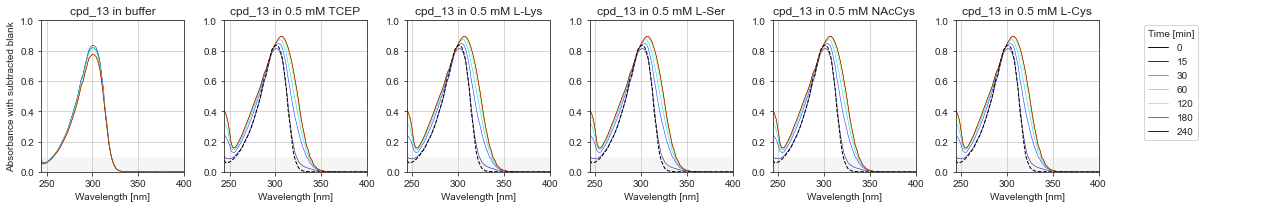

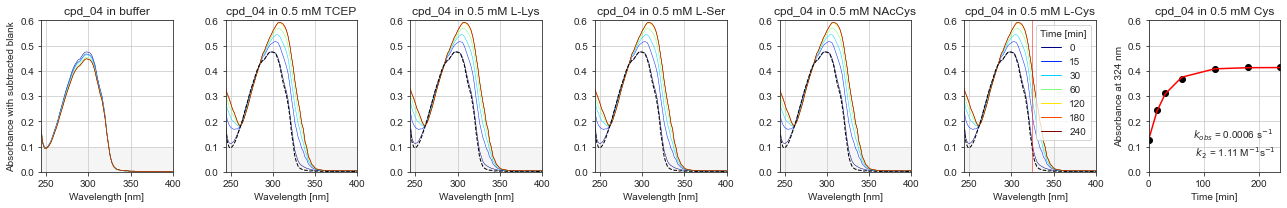

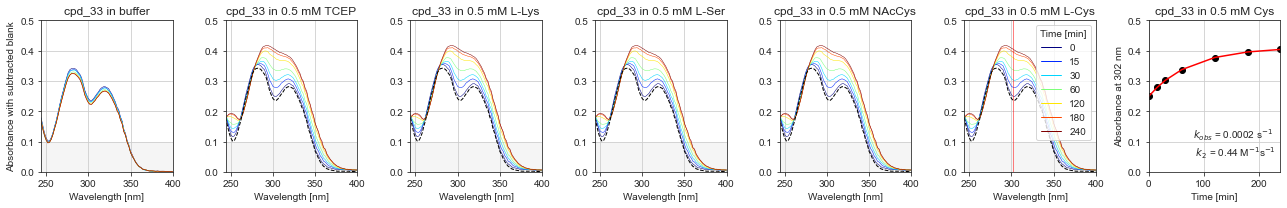

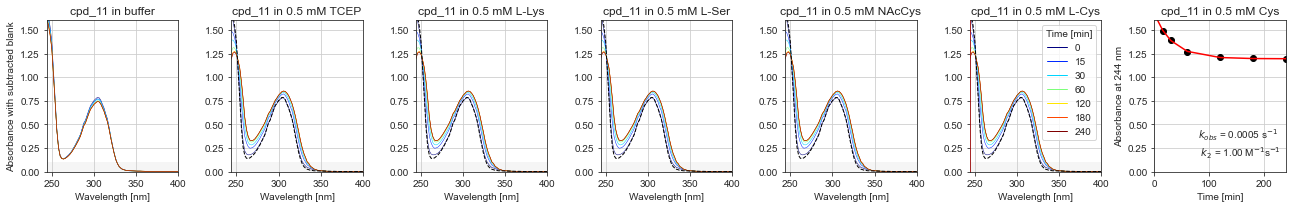

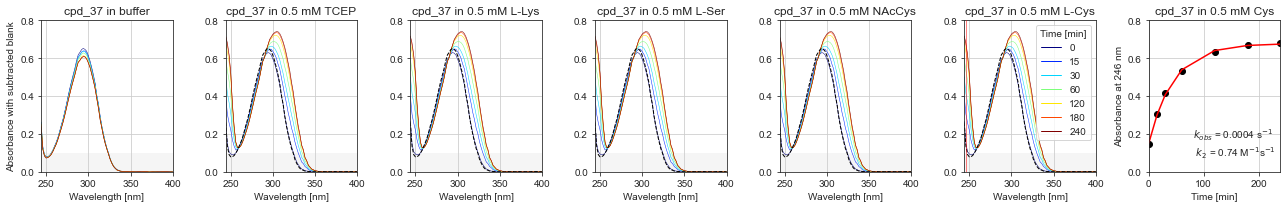

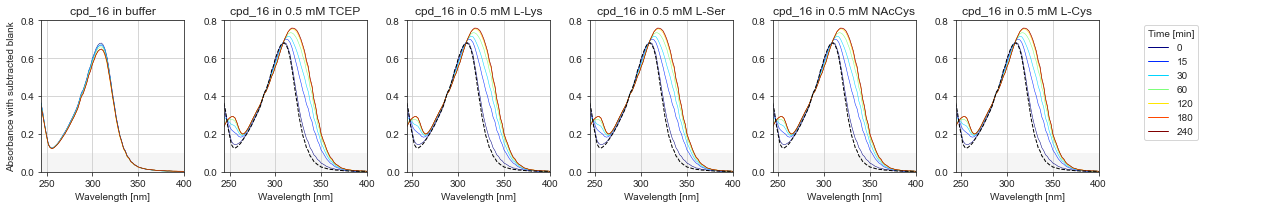

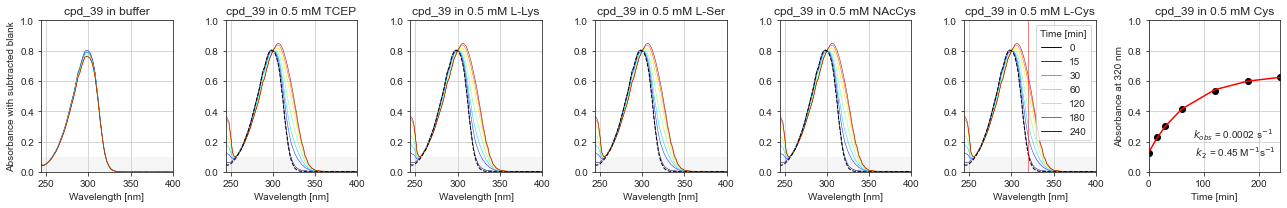

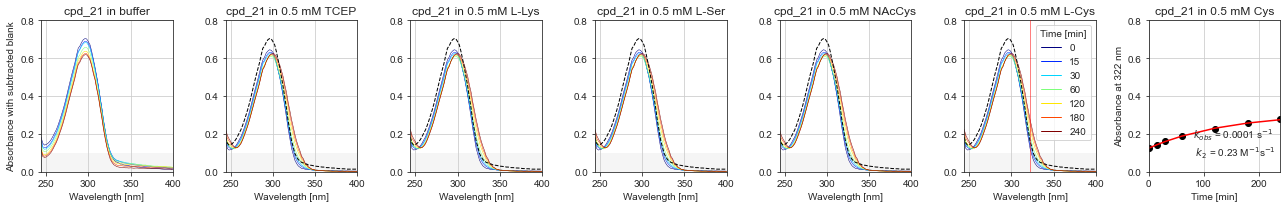

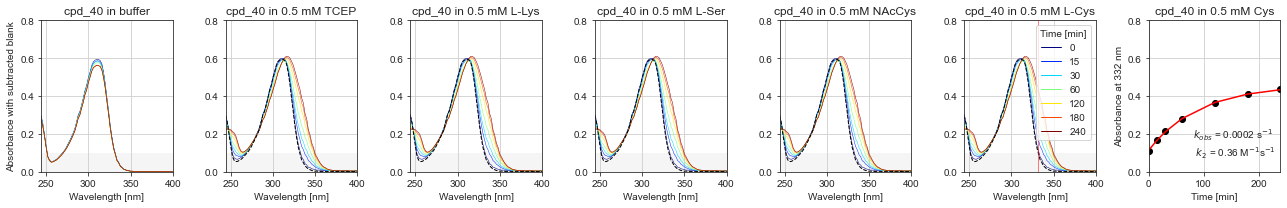

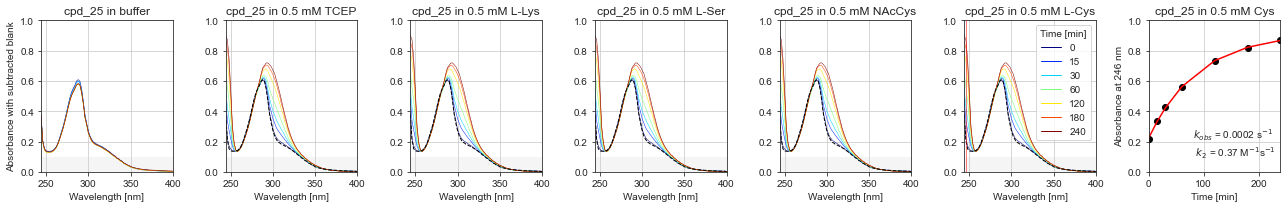

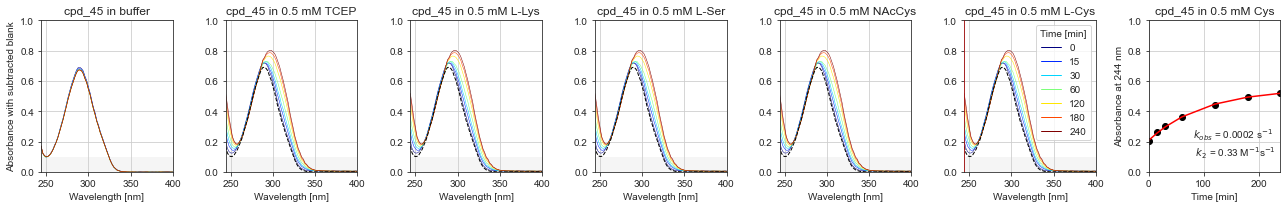

In [8]:
# Create new output file if doesn't exist
wb = openpyxl.Workbook()
if not os.path.exists(workbook_name):
    wb.save(workbook_name)

# Create output dataframe
df_out = pd.DataFrame(cpds, columns=['Label']).drop_duplicates()
df_out = df_out[df_out['Label'].str.contains('blank')==False] # remove blanks
df_out.set_index('Label', inplace=True, drop=False)
    
# Worksheet preferences
wb = openpyxl.load_workbook(workbook_name)
ws = wb.create_sheet(sheet_name)

for row in range(2, len(df_out.index) + 2):
    ws.row_dimensions[row].height = 106
ws.column_dimensions[fig_col].width = 108
ws[fig_col+'1'] = 'Absorbance spectra, 50 μM compound'
wb.save(filename=workbook_name)
row_num = 2 

# Create figure output directory
current_directory = os.getcwd()
final_directory = os.path.join(current_directory, 'figures\\'+date)
if not os.path.exists(final_directory):
    os.makedirs(final_directory)
    
######################################################
# Loop through compounds 
for cpd in tqdm(df_out.index): 
    
    # the first condition (buffer) will be used as a reference:
    cpd_b = cpd + '_' + conditions[0] 
    
    ####################### CALCULATIONS ######################## 
    ### Loop through conditions
    for condition in conditions:
        cpd_c = cpd + '_' + condition
        
        ### Most responsive wavelengths
        try: # use only datapoints above 0.1 AU
            abs_res_c = df_blanked['Wavelength'].loc[ \
                        abs((df_blanked[cpd_c].iloc[:, timepoints-1].loc[lambda x: x >= 0.1] - \
                             df_blanked[cpd_c].iloc[:, 0].loc[lambda x: x >= 0.1]).fillna(0)).idxmax()]['Time [min]']
            df_out.loc[cpd, [condition + '_Most responsive wavelength']] = abs_res_c
        except ValueError: # if there is no points above 0.1 AU
            abs_res_c = df_blanked['Wavelength'].loc[abs(df_blanked[cpd_c].iloc[:, timepoints-1] - df_blanked[cpd_c].iloc[:, 0]).idxmax()]['Time [min]']
            df_out.loc[cpd, [condition + '_Most responsive wavelength']] = abs_res_c
            
        abs_res_c_t0 = df_blanked[cpd_c].loc[wl_to_index(abs_res_c, df_blanked)][0]
        df_out.loc[cpd, [condition + '_Abs at most responsive wavelength, t=0']] = abs_res_c_t0
        
        abs_res_c_t60 = df_blanked[cpd_c].loc[wl_to_index(abs_res_c, df_blanked)][60]
        df_out.loc[cpd, [condition + '_Abs at most responsive wavelength, t=60']] = abs_res_c_t60

        abs_res_c_t240 = df_blanked[cpd_c].loc[wl_to_index(abs_res_c, df_blanked)][240]
        df_out.loc[cpd, [condition + '_Abs at most responsive wavelength, t=240']] = abs_res_c_t240
        
        ### Absolute difference at most responsive wavelength
        # 60 min
        abs_res_c_diff_60 = abs(abs_res_c_t0 - abs_res_c_t60)
        df_out.loc[cpd, [condition + '_Abs. diff. at most responsive wavelength (0-60 min)']] = abs_res_c_diff_60  
        
        # 240 min
        abs_res_c_diff_240 = abs(abs_res_c_t0 - abs_res_c_t240)
        df_out.loc[cpd, [condition + '_Abs. diff. at most responsive wavelength (0-240 min)']] = abs_res_c_diff_240
            
        ### Relative difference to max at most responsive wavelength
        # 60 min
        if abs_res_c_t0 > abs_res_c_t60:
            rel_diff_c_60 = abs_res_c_diff_60 / abs_res_c_t0
        else: 
            rel_diff_c_60 = abs_res_c_diff_60 / abs_res_c_t60
        df_out.loc[cpd, [condition + '_Rel. diff. to max at most responsive wavelength (0-60 min)']] = rel_diff_c_60     
        
        # 240 min
        if abs_res_c_t0 > abs_res_c_t240:
            rel_diff_c_240 = abs_res_c_diff_240 / abs_res_c_t0
        else: 
            rel_diff_c_240 = abs_res_c_diff_240 / abs_res_c_t240
        df_out.loc[cpd, [condition + '_Rel. diff. to max at most responsive wavelength (0-240 min)']] = rel_diff_c_240     
        
        
        
    # Absorbance max all conditions
    abs_max_value = max(df_blanked.filter(like=cpd, axis=1).max())
    df_out.loc[cpd, ['Absorbance max']] = abs_max_value
    
    #### Thresholds
    # Aqueous stability
    aq_stab = ''
    rel_diff_b_240 = df_out['buffer_Rel. diff. to max at most responsive wavelength (0-240 min)'][cpd]
    
    if abs_max_value < 0.1:
        aq_stab = 'Low absorbance'
        stable = False
    elif rel_diff_b_240 < 0.1:
        aq_stab = 'Stable'
        stable = True
    elif rel_diff_b_240 > 0.2:
        aq_stab = 'Unstable'
        stable = False
    else:
        aq_stab = 'Intermediate'
        stable = True
    
    df_out.loc[cpd, ['Aqueous stability']] = aq_stab
        
        
        
    ### Loop through conditions (except buffer)
    for condition in conditions[1:]:
        cpd_c = cpd + '_' + condition        

        ### Reactivity at t=0
        # Most responsive wavelengths
        try: # use only datapoints above 0.1 AU
            abs_res_bc_t0 = df_blanked['Wavelength'].loc[ \
                    abs((df_blanked[cpd_b].iloc[:, 0].loc[lambda x: x >= 0.1] - \
                         df_blanked[cpd_c].iloc[:, 0].loc[lambda x: x >= 0.1]).fillna(0)).idxmax()]['Time [min]']
            df_out.loc[cpd, ['t=0_' + condition + '_most responsive wavelength']] = abs_res_bc_t0   
        except ValueError: # if there is no points above 0.1 AU
            abs_res_bc_t0 = df_blanked['Wavelength'].loc[abs(df_blanked[cpd_b].iloc[:, 0] - df_blanked[cpd_c].iloc[:, 0]).idxmax()]['Time [min]']
            df_out.loc[cpd, ['t=0_' + condition + '_most responsive wavelength']] = abs_res_bc_t0               

        abs_res_bc_t0_b = df_blanked[cpd_b].loc[wl_to_index(abs_res_bc_t0, df_blanked)][0]
        df_out.loc[cpd, ['t=0_' + condition + '_abs at most responsive wavelength_buffer']] = abs_res_bc_t0_b 

        abs_res_bc_t0_c = df_blanked[cpd_c].loc[wl_to_index(abs_res_bc_t0, df_blanked)][0]    
        df_out.loc[cpd, ['t=0_' + condition + '_abs at most responsive wavelength_' + condition]] = abs_res_bc_t0_c  

        # absolute difference
        abs_res_bc_t0_diff = abs(abs_res_bc_t0_b - abs_res_bc_t0_c)
        df_out.loc[cpd, ['t=0_' + condition + '_abs. diff. at most responsive wavelength']] = abs_res_bc_t0_diff 

        # relative difference to max at most responsive wavelength
        if abs_res_bc_t0_b > abs_res_bc_t0_c:
            rel_diff_bc_t0 = abs_res_bc_t0_diff / abs_res_bc_t0_b
        else: 
            rel_diff_bc_t0 = abs_res_bc_t0_diff / abs_res_bc_t0_c    
        df_out.loc[cpd, ['t=0_' + condition + '_relative diff. at most responsive wavelength']] = rel_diff_bc_t0
    
        # Thresholds: reactivity for each condition
        reac_c = ''
        rel_diff_c_240 = df_out[condition + '_Rel. diff. to max at most responsive wavelength (0-240 min)'][cpd]
        rel_diff_bc_t0 = df_out['t=0_' + condition + '_relative diff. at most responsive wavelength'][cpd]

        if rel_diff_bc_t0 > 0.2:
            reac_c = 'Reactivity above the limit of detection'
        elif rel_diff_c_240 > 0.2:
            reac_c = 'Reactive'
        else:
            reac_c = 'Not reactive'    

        df_out.loc[cpd, ['Reactivity with ' + condition]] = reac_c

    # Plot and calculate kinetics only for compounds moderately reactive with L-Cys:
    if df_out['Reactivity with 0.5 mM L-Cys'][cpd]=='Reactive':
        kinetics = True
    else:
        kinetics = False
    
    ####################### PLOT ########################
    fig, ax = plt.subplots(nrows=1, ncols=7,figsize=(18,3))
    sns.set_style("ticks")
    ax = ax.ravel()
    colors = plt.cm.jet(np.linspace(0,1,timepoints)) 
    
    ######## LIMITS
    xlims = (w_min,w_max)
    
    ylims = (0,0.1)    
    if abs_max_value > 0.1:
        ylims = (0,0.2)
    if abs_max_value > 0.2:
        ylims = (0,0.3)
    if abs_max_value > 0.3:
        ylims = (0,0.4)
    if abs_max_value > 0.4:
        ylims = (0,0.5)
    if abs_max_value > 0.5:
        ylims = (0,0.6)
    if abs_max_value > 0.6:
        ylims = (0,0.8)
    if abs_max_value > 0.8:
        ylims = (0,1)
    if abs_max_value > 1:
        ylims = (0,1.2)
    if abs_max_value > 1.2:
        ylims = (0,1.4)
    if abs_max_value > 1.4:
        ylims = (0,1.6)

    ######## Buffer plot
    i=0 
    for t in np.arange(0,timepoints):
        ax[i].plot(df_blanked['Wavelength'], df_blanked[cpd_b].iloc[:, t], linewidth=0.5, color=colors[t])  

    ax[i].set_xlim(xlims)
    ax[i].set_ylim(ylims)
    ax[i].set_xlabel('Wavelength [nm]')
    ax[i].set_ylabel('Absorbance with subtracted blank')
    ax[i].set_title(str(df_out.loc[cpd].name) + ' in buffer')
    ax[i].grid(which='major', axis='both')
    ax[i].add_patch(mpatches.Rectangle((w_min,0), w_max-w_min, 0.1, color='whitesmoke', zorder=0))
#     abs_res_b = df_out['buffer_Most responsive wavelength'][cpd]
#     ax[i].axvline(abs_res_b,lw=0.5,color='Red', zorder=4)
    
    if stable:
        i=1
        for condition in conditions[1:]:
            for t in np.arange(0,timepoints):
                ax[i].plot(df_blanked['Wavelength'], df_blanked[cpd_c].iloc[:, t], linewidth=0.5, color=colors[t])  
            ax[i].plot(df_blanked['Wavelength'], df_blanked[cpd_b].iloc[:, 0], linewidth=1, color='Black', linestyle='dashed')  

            ax[i].set_xlim(xlims)
            ax[i].set_ylim(ylims)
            ax[i].set_xlabel('Wavelength [nm]')
            ax[i].set_ylabel('')
            ax[i].set_title(str(df_out.loc[cpd].name) + ' in ' + condition)
            ax[i].grid(which='major', axis='both')    
            ax[i].add_patch(mpatches.Rectangle((w_min,0), w_max-w_min, 0.1, color='whitesmoke', zorder=0))
            
            i+=1
        
        ####### Kinetics calculation and plot
        if kinetics: 
            i=6
            wl = df_out['0.5 mM L-Cys_Most responsive wavelength'][cpd]
            ax[i-1].axvline(wl,lw=0.5,color='Red', zorder=4)
        
            x = df_blanked[cpd_c].loc[wl_to_index(wl,df_blanked)].index
            y = df_blanked[cpd_c].loc[wl_to_index(wl,df_blanked)].tolist()

            popt, pcov = curve_fit(one_phase_decay, x, y)
            ax[i].plot(x, y, 'ko', label="Original Data")
            ax[i].plot(x, one_phase_decay(x, *popt), 'r-', label="Fitted Curve")
            ax[i].text(80,ylims[1]/10,'$k_{obs}$ = ' + f'{popt[2]/60:.4f}'+' s$^{-1}$'+f"\n $k_{2}$ = "+f'{(popt[2]/60)/0.0005:.2f}'+' M$^{-1}$s$^{-1}$')
            ax[i].set_xlim(0,240)
            ax[i].set_ylim(ylims)
            ax[i].set_xlabel('Time [min]')
            ax[i].set_ylabel('Absorbance at ' + str(int(wl)) + ' nm')
            ax[i].set_title(str(df_out.loc[cpd].name) + ' in 0.5 mM Cys')
            ax[i].grid(which='major', axis='both')

            df_out.loc[cpd, ['Y0']] = popt[0]
            df_out.loc[cpd, ['Plateau']] = popt[1]
            df_out.loc[cpd, ['kobs [min-1]']] = popt[2]
            df_out.loc[cpd, ['kobs [s-1]']] = popt[2]/60 # convert from min to s
            df_out.loc[cpd, ['k2 [M-1s-1]']] = (popt[2]/60)/0.0005 # kobs = k2[Cys]
    
    # create custom legend
    custom_lines = []
    for t in np.arange(0,timepoints):
        custom_lines.append(plt.Line2D([0], [0], color=colors[t], lw=1))

    if stable and kinetics:
        ax[5].legend(custom_lines, timepoints_list, title='Time [min]')
    elif stable and not kinetics:
        ax[6].legend(custom_lines, timepoints_list, title='Time [min]', loc='upper left')
    elif not stable:
        ax[1].legend(custom_lines, timepoints_list, title='Time [min]', loc='upper left')
        #Empty axes
        for n in [1,2,3,4,5]:
            ax[n].get_xaxis().set_visible(False)
            ax[n].get_yaxis().set_visible(False)
            ax[n].axis('off')
            
    if not kinetics:
        for n in [6]:
            ax[n].get_xaxis().set_visible(False)
            ax[n].get_yaxis().set_visible(False)
            ax[n].axis('off')        
            
    ######################################################
    plt.tight_layout()
    fig.savefig(os.path.join(final_directory, str(df_out.loc[cpd].name)+'_spectrum.png'), dpi=150)
    #plt.close()
    
    ####################### EXCEL ########################
    # Add figures to the excel file
    wb = openpyxl.load_workbook(workbook_name)
    ws = wb[sheet_name]

    img = openpyxl.drawing.image.Image(os.path.join(final_directory, str(df_out.loc[cpd].name)+'_spectrum.png'))
    img.height = img.height*0.313
    img.width = img.width*0.313
    img.anchor = fig_col + str(row_num)
    ws.add_image(img)
    wb.save(filename=workbook_name)
    wb.close()

    row_num +=1

######################################################
## Export df_out
append_df_to_excel(filename=workbook_name, df=df_out, sheet_name=sheet_name, startrow=0, index=False)

print('Finished')